# Wet and Dry Spells Compare: Historical, CN1, CN2, and Custom CN

The purpose of this notebook is to compare the monthly distributions of spell lengths obtained from historical observations and future climate model projections.

There are two types of spells of contiguous days for each month: 1) wet and 2) dry. Empirical distributions are plotted and compared among the four sources. Empirical distributions are just normalized histograms. Additionally, negative binomial distributions are fit to each month and spell length.

The four information sources are:

1. Historical from DayMet
2. CN1: 2021-2050 (selected downscaled climate model simulation results)
3. CN2: 2021-2050 (selected downscaled climate model simulation results)
4. Custom CN: 2031-2060 (selected downscaled climate model simulation results)


It is difficult to fit negative binomial distributions (and all discrete distributions). So use a simple workaround here where calculate the $n$ and $p$ parameters for this distribution from data. $n$ and $p$ are shape parameters where $n$ is the number of successes, $p$ is the probability of a single success, and $1-p$ is the probability of a single failure. These two parameters can be calculated from the sample mean, here $\mu$, and variance, here $\sigma^{2}$.

\begin{equation*}
    n = \frac{\mu^{2}}{\sigma^{2} - \mu}
\end{equation*}
\begin{equation*}
    p = \frac{\mu}{\sigma^{2}}
\end{equation*}

## Parameters and Imports

In [1]:
%matplotlib inline

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import datetime as dt
from copy import deepcopy
from IPython.display import display, HTML, Image
from scipy import stats as sstats
import math

In [3]:
IN_DIR1 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\Processed_Historical'
IN_DIR2 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\CombinedFuture'
IN_DIR3 = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\DayMet_GridIntersect'
OUT_DIR = r'C:\Users\nmartin\Documents\EAA_HCP\Data\SwRI_Processed\CombinedFuture\SpellLength'

In [4]:
# full basin intersection dictionary
InFiler = os.path.normpath( os.path.join( IN_DIR3, "BasWeightsGDF.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    BasWeightsDF = pickle.load( IF )
# end with
BAS_KEYS = sorted( BasWeightsDF.keys() )

In [5]:
# plotting stuff
pmfYVals = np.linspace( 0.00, 1.0, 101, dtype=np.float32 )
xPTicks = [0, 5, 10, 15, 20, 25, 30,]

In [6]:
colors = [ 'xkcd:cobalt blue', 'xkcd:ocean blue', 'xkcd:bright blue', 'xkcd:light grey blue', ]
labels = ["Obs. 1991-2020", "CN1 2021-2050", "CCN 2031-2060", "CN2 2051-2080",]

In [7]:
MonDict = { 1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 7 : "Jul", 8 : "Aug",
            9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec", }
MonKeys = sorted( MonDict.keys() )

## Dry Days

In [8]:
# load the dictionaries.
InFiler = os.path.normpath( os.path.join( IN_DIR1, "Hist_FullB_Cont_Dry_dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    HistDict = pickle.load( IF )
# end with

In [9]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, "CN1_FullB_Cont_Dry_dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    CN1Dict = pickle.load( IF )
# end with

In [10]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, "CN2_FullB_Cont_Dry_dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    CN2Dict = pickle.load( IF )
# end with

In [11]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, "CCN_FullB_Cont_Dry_dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    CCNDict = pickle.load( IF )
# end with

### Test

In [12]:
bas = BAS_KEYS[0]
bas

'Blanco'

In [13]:
HistMCntsDict = HistDict[bas]
CN1MCntsDict = CN1Dict[bas]
CN2MCntsDict = CN2Dict[bas]
CCNMCntsDict = CCNDict[bas]

In [14]:
mon = 7

In [15]:
cHistCnts = HistMCntsDict[mon]
cCN1Cnts = CN1MCntsDict[mon]
cCN2Cnts = CN2MCntsDict[mon]
cCCNCnts = CCNMCntsDict[mon]

In [16]:
# look at the fits first
npHist = np.array( cHistCnts, dtype=np.int32 )
npCN1 = np.array( cCN1Cnts, dtype=np.int32 )
npCN2 = np.array( cCN2Cnts, dtype=np.int32 )
npCCN = np.array( cCCNCnts, dtype=np.int32 )

In [17]:
HistMax = npHist.max()
CN1Max = npCN1.max()
CN2Max = npCN2.max()
CCNMax = npCCN.max()

In [18]:
HistMin = npHist.min()
CN1Min = npCN1.min()
CN2Min = npCN2.min()
CCNMin = npCCN.min()

In [19]:
HistMean = npHist.mean()
CN1Mean = npCN1.mean()
CN2Mean = npCN2.mean()
CCNMean = npCCN.mean()

In [20]:
HistMed = np.median( npHist )
CN1Med = np.median( npCN1 )
CN2Med = np.median( npCN2 )
CCNMed = np.median( npCCN )

In [21]:
HistVar = npHist.var()
CN1Var = npCN1.var()
CN2Var = npCN2.var()
CCNVar = npCCN.var()

In [22]:
HistCnt = len( npHist )
CN1Cnt = len( npCN1 )
CN2Cnt = len( npCN2 )
CCNCnt = len( npCCN )

In [23]:
HistN = math.pow( HistMean, 2.0 ) / (HistVar - HistMean)
CN1N = math.pow( CN1Mean, 2.0 ) / (CN1Var - CN1Mean)
CN2N = math.pow( CN2Mean, 2.0 ) / (CN2Var - CN2Mean)
CCNN = math.pow( CCNMean, 2.0 ) / (CCNVar - CCNMean)
HistN, CN1N, CN2N, CCNN

(0.7764765355126799,
 0.8564038580653116,
 0.7850253460408412,
 0.7963336816473915)

In [24]:
HistP = HistMean / HistVar
CN1P = CN1Mean / CN1Var
CN2P = CN2Mean / CN2Var
CCNP = CCNMean / CCNVar
HistP, CN1P, CN2P, CCNP

(0.07483046223400108,
 0.07314105468961063,
 0.06146744982936224,
 0.06861944651219594)

In [25]:
HistNBinomRV = sstats.nbinom( HistN, HistP, loc=0 )
CN1NBinomRV = sstats.nbinom( CN1N, CN1P, loc=0 )
CN2NBinomRV = sstats.nbinom( CN2N, CN2P, loc=0 )
CCNNBinomRV = sstats.nbinom( CCNN, CCNP, loc=0 )

In [26]:
HistNBinomRV.stats(), HistMean, HistVar

((array(9.6), array(128.29)), 9.6, 128.29000000000002)

In [27]:
MaxMax = max( [HistMax, CN1Max, CN2Max, CCNMax] )
MaxMax

117

In [28]:
bins = np.linspace( 0, MaxMax, num=MaxMax+1, dtype=np.int32 )
bins

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117])

In [29]:
yPTicks = [ 0.0, 0.05, 0.10, 0.15, 0.20, 0.25, ]

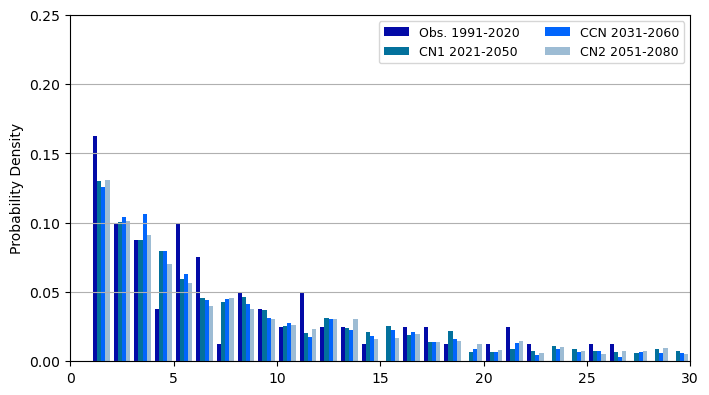

In [30]:
# plot normalized
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 4.5)
ax11 = Fig1.add_subplot(111)
histInfo = ax11.hist( [npHist, npCN1, npCCN, npCN2,], bins, density=True, histtype='bar', color=colors,
                      label=labels, )
ax11.set_xticks( xPTicks )
ax11.set_yticks( yPTicks )
ax11.set_ylabel('Probability Density', fontsize=10)
ax11.set_ylim( (yPTicks[0], yPTicks[len(yPTicks)-1]) )
ax11.set_xlim( (xPTicks[0], xPTicks[len(xPTicks)-1]) )
ax11.tick_params(axis='both', which='major', labelsize=10)
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.legend( loc='upper right', fontsize=9, ncol=2 )
ax11.grid(visible=True, which='major', axis='y' )

In [31]:
HistNBinomRVLoc1 = sstats.nbinom( HistN, HistP, loc=1 )
HistNBinomRVLoc2 = sstats.nbinom( HistN, HistP, loc=2 )

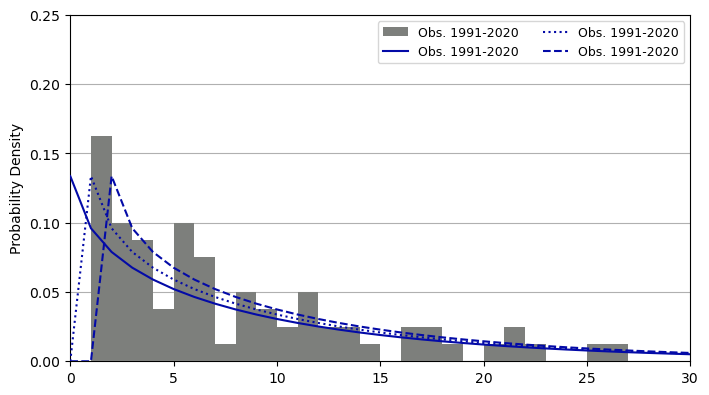

In [32]:
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 4.5)
ax11 = Fig1.add_subplot(111)
histhist = ax11.hist( npHist, bins, density=True, histtype='bar', color='xkcd:medium grey',
                      label=labels[0], zorder=5, ) 
histpmf, = ax11.plot( bins, HistNBinomRV.pmf( bins ), color=colors[0], label=labels[0],
                      linewidth=1.5, linestyle='-', zorder=10, )
hist1pmf, = ax11.plot( bins, HistNBinomRVLoc1.pmf( bins ), color=colors[0], label=labels[0],
                       linewidth=1.5, linestyle=':', zorder=11, )
hist2pmf, = ax11.plot( bins, HistNBinomRVLoc2.pmf( bins ), color=colors[0], label=labels[0],
                       linewidth=1.5, linestyle='dashed', zorder=12, )
ax11.set_xticks( xPTicks )
ax11.set_yticks( yPTicks )
ax11.set_ylabel('Probability Density', fontsize=10)
ax11.set_ylim( (yPTicks[0], yPTicks[len(yPTicks)-1]) )
ax11.set_xlim( (xPTicks[0], xPTicks[len(xPTicks)-1]) )
ax11.tick_params(axis='both', which='major', labelsize=10)
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.legend( loc='upper right', fontsize=9, ncol=2 )
ax11.grid(visible=True, which='major', axis='y' )

In [33]:
HistNBinomRVLoc1.pmf( 30 )

0.005518399909439109

In [34]:
MaxMax = max( [HistNBinomRV.pmf( bins ).max(), CN1NBinomRV.pmf( bins ).max(), CCNNBinomRV.pmf( bins ).max(), CN2NBinomRV.pmf( bins ).max(), ] )
MaxMax

0.13358211595072023

In [35]:
yPTicks = [ 0.0, 0.03, 0.06, 0.09, 0.12, 0.15 ]

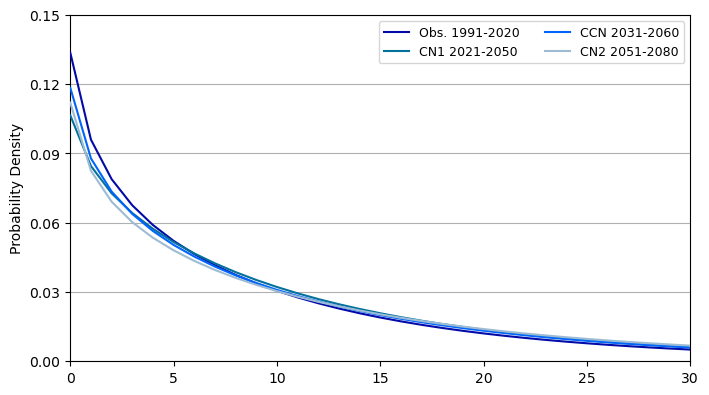

In [36]:
Fig1 = plt.figure()
Fig1.set_size_inches(8.0, 4.5)
ax11 = Fig1.add_subplot(111)
histpmf, = ax11.plot( bins, HistNBinomRV.pmf( bins ), color=colors[0], label=labels[0],
                      linewidth=1.5, linestyle='-', zorder=5, )
histCN1, = ax11.plot( bins, CN1NBinomRV.pmf( bins ), color=colors[1], label=labels[1],
                      linewidth=1.5, linestyle='-', zorder=7, )
histCCN, = ax11.plot( bins, CCNNBinomRV.pmf( bins ), color=colors[2], label=labels[2],
                      linewidth=1.5, linestyle='-', zorder=9, )
histCN2, = ax11.plot( bins, CN2NBinomRV.pmf( bins ), color=colors[3], label=labels[3],
                      linewidth=1.5, linestyle='-', zorder=11, )
ax11.set_xticks( xPTicks )
ax11.set_yticks( yPTicks )
ax11.set_ylabel('Probability Density', fontsize=10)
ax11.set_ylim( (yPTicks[0], yPTicks[len(yPTicks)-1]) )
ax11.set_xlim( (xPTicks[0], xPTicks[len(xPTicks)-1]) )
ax11.tick_params(axis='both', which='major', labelsize=10)
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
ax11.legend( loc='upper right', fontsize=9, ncol=2 )
ax11.grid(visible=True, which='major', axis='y' )

### Loop through All

Make the stats tracking DataFrame

In [37]:
ColNames = [ "HistObs_1991to2020", "CN1_2021to2050", "CCN_2031to2060", "CN2_2051to2080" ]

In [38]:
RowIndNames = [ "Counts (N)", "Max", "Mean", "Median", "Min", "Var", "nb_N", "nb_P", "loc", "prob_30d" ]

In [39]:
StatsTrackTemplate = pd.DataFrame( 0, columns=ColNames, index=RowIndNames, dtype=np.float32 )

Now loop through all months and collate and make our outputs

In [40]:
for bas in BAS_KEYS:
    HistMCntsDict = HistDict[bas]
    CN1MCntsDict = CN1Dict[bas]
    CN2MCntsDict = CN2Dict[bas]
    CCNMCntsDict = CCNDict[bas]
    StatsTrackDict = dict()
    for mon in MonKeys:
        StatsTrackDict[mon] = StatsTrackTemplate.copy()
    # end for
    for mon in MonKeys:
        cLabel = MonDict[mon]
        cHistCnts = HistMCntsDict[mon]
        cCN1Cnts = CN1MCntsDict[mon]
        cCN2Cnts = CN2MCntsDict[mon]
        cCCNCnts = CCNMCntsDict[mon]
        npHist = np.array( cHistCnts, dtype=np.int32 )
        npCN1 = np.array( cCN1Cnts, dtype=np.int32 )
        npCN2 = np.array( cCN2Cnts, dtype=np.int32 )
        npCCN = np.array( cCCNCnts, dtype=np.int32 )
        # maximums
        HistMax = npHist.max()
        CN1Max = npCN1.max()
        CN2Max = npCN2.max()
        CCNMax = npCCN.max()
        StatsTrackDict[mon].at["Max", ColNames[0]] = HistMax
        StatsTrackDict[mon].at["Max", ColNames[1]] = CN1Max
        StatsTrackDict[mon].at["Max", ColNames[2]] = CCNMax
        StatsTrackDict[mon].at["Max", ColNames[3]] = CN2Max
        DaysMax = max( [HistMax, CN1Max, CN2Max, CCNMax ] )
        bins = np.linspace( 0, DaysMax, num=DaysMax+1, dtype=np.int32 )
        # minimums
        HistMin = npHist.min()
        CN1Min = npCN1.min()
        CN2Min = npCN2.min()
        CCNMin = npCCN.min()
        StatsTrackDict[mon].at["Min", ColNames[0]] = HistMin
        StatsTrackDict[mon].at["Min", ColNames[1]] = CN1Min
        StatsTrackDict[mon].at["Min", ColNames[2]] = CCNMin
        StatsTrackDict[mon].at["Min", ColNames[3]] = CN2Min
        # means
        HistMean = npHist.mean()
        CN1Mean = npCN1.mean()
        CN2Mean = npCN2.mean()
        CCNMean = npCCN.mean()
        StatsTrackDict[mon].at["Mean", ColNames[0]] = HistMean
        StatsTrackDict[mon].at["Mean", ColNames[1]] = CN1Mean
        StatsTrackDict[mon].at["Mean", ColNames[2]] = CCNMean
        StatsTrackDict[mon].at["Mean", ColNames[3]] = CN2Mean
        # medians
        HistMed = np.median( npHist )
        CN1Med = np.median( npCN1 )
        CN2Med = np.median( npCN2 )
        CCNMed = np.median( npCCN )
        StatsTrackDict[mon].at["Median", ColNames[0]] = HistMed
        StatsTrackDict[mon].at["Median", ColNames[1]] = CN1Med
        StatsTrackDict[mon].at["Median", ColNames[2]] = CCNMed
        StatsTrackDict[mon].at["Median", ColNames[3]] = CN2Med
        # variances
        HistVar = npHist.var()
        CN1Var = npCN1.var()
        CN2Var = npCN2.var()
        CCNVar = npCCN.var()
        StatsTrackDict[mon].at["Var", ColNames[0]] = HistVar
        StatsTrackDict[mon].at["Var", ColNames[1]] = CN1Var
        StatsTrackDict[mon].at["Var", ColNames[2]] = CCNVar
        StatsTrackDict[mon].at["Var", ColNames[3]] = CN2Var
        # counts
        HistCnt = len( npHist )
        CN1Cnt = len( npCN1 )
        CN2Cnt = len( npCN2 )
        CCNCnt = len( npCCN )
        StatsTrackDict[mon].at["Counts (N)", ColNames[0]] = HistCnt
        StatsTrackDict[mon].at["Counts (N)", ColNames[1]] = CN1Cnt
        StatsTrackDict[mon].at["Counts (N)", ColNames[2]] = CCNCnt
        StatsTrackDict[mon].at["Counts (N)", ColNames[3]] = CN2Cnt
        # NB, N parameter
        HistN = math.pow( HistMean, 2.0 ) / (HistVar - HistMean)
        CN1N = math.pow( CN1Mean, 2.0 ) / (CN1Var - CN1Mean)
        CN2N = math.pow( CN2Mean, 2.0 ) / (CN2Var - CN2Mean)
        CCNN = math.pow( CCNMean, 2.0 ) / (CCNVar - CCNMean)
        StatsTrackDict[mon].at["nb_N", ColNames[0]] = HistN
        StatsTrackDict[mon].at["nb_N", ColNames[1]] = CN1N
        StatsTrackDict[mon].at["nb_N", ColNames[2]] = CCNN
        StatsTrackDict[mon].at["nb_N", ColNames[3]] = CN2N
        # NB, P parameter
        HistP = HistMean / HistVar
        CN1P = CN1Mean / CN1Var
        CN2P = CN2Mean / CN2Var
        CCNP = CCNMean / CCNVar
        StatsTrackDict[mon].at["nb_P", ColNames[0]] = HistP
        StatsTrackDict[mon].at["nb_P", ColNames[1]] = CN1P
        StatsTrackDict[mon].at["nb_P", ColNames[2]] = CCNP
        StatsTrackDict[mon].at["nb_P", ColNames[3]] = CN2P
        # distributions
        HistNBinomRV = sstats.nbinom( HistN, HistP, loc=1 )
        CN1NBinomRV = sstats.nbinom( CN1N, CN1P, loc=1 )
        CN2NBinomRV = sstats.nbinom( CN2N, CN2P, loc=1 )
        CCNNBinomRV = sstats.nbinom( CCNN, CCNP, loc=1 )
        StatsTrackDict[mon].at["loc", ColNames[0]] = 1.0
        StatsTrackDict[mon].at["loc", ColNames[1]] = 1.0
        StatsTrackDict[mon].at["loc", ColNames[2]] = 1.0
        StatsTrackDict[mon].at["loc", ColNames[3]] = 1.0
        StatsTrackDict[mon].at["prob_30d", ColNames[0]] = HistNBinomRV.pmf( 30 )
        StatsTrackDict[mon].at["prob_30d", ColNames[1]] = CN1NBinomRV.pmf( 30 )
        StatsTrackDict[mon].at["prob_30d", ColNames[2]] = CCNNBinomRV.pmf( 30 )
        StatsTrackDict[mon].at["prob_30d", ColNames[3]] = CN2NBinomRV.pmf( 30 )
        # get the maximum probability density
        MaxPDen = max( [HistNBinomRV.pmf( bins ).max(), CN1NBinomRV.pmf( bins ).max(), CCNNBinomRV.pmf( bins ).max(), 
                        CN2NBinomRV.pmf( bins ).max(), ] )
        # allocate maximum pDen
        if MaxPDen < 0.15:
            MaxYPlot = 0.15
            yPTicks = [ 0.0, 0.03, 0.06, 0.09, 0.12, 0.15 ]
        elif MaxPDen < 0.20:
            MaxYPlot = 0.20
            yPTicks = [0.0, 0.05, 0.10, 0.15, 0.20]
        elif MaxPDen < 0.30:
            MaxYPlot = 0.30
            yPTicks = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, ]
        elif MaxPDen < 0.40:
            MaxYPlot = 0.40
            yPTicks = [0.0, 0.10, 0.20, 0.30, 0.40, ]
        else:
            MaxYPlot = 0.50
            yPTicks = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, ]
        # end if
        # do the plots
        #     plot normalized histograms
        OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_DryDays_Hist_%s.svg" % (bas, cLabel ) ) )
        OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_DryDays_Hist_%s.png" % (bas, cLabel ) ) )
        OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_DryDays_Hist_%s.pdf" % (bas, cLabel ) ) )
        Fig1 = plt.figure()
        Fig1.set_size_inches(8.0, 4.5)
        ax11 = Fig1.add_subplot(111)
        histInfo = ax11.hist( [npHist, npCN1, npCCN, npCN2,], bins, density=True, histtype='bar', color=colors,
                              label=labels, )
        ax11.set_xticks( xPTicks )
        ax11.set_yticks( yPTicks )
        ax11.set_ylabel('Probability Density', fontsize=10)
        ax11.set_xlabel('%s Dry Spell Length (days)' % cLabel, fontsize=10)
        ax11.set_ylim( (yPTicks[0], yPTicks[len(yPTicks)-1]) )
        ax11.set_xlim( (xPTicks[0], xPTicks[len(xPTicks)-1]) )
        ax11.tick_params(axis='both', which='major', labelsize=10)
        ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
        ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
        ax11.legend( loc='upper right', fontsize=9, ncol=2 )
        ax11.grid(visible=True, which='major', axis='y' )
        Fig1.savefig( OutSVG, dpi=600.0 )
        Fig1.savefig( OutPNG, dpi=600.0 )
        Fig1.savefig( OutPDF, dpi=600.0 )
        # clear the figures
        plt.cla()
        plt.close(Fig1)
        #     plot PDFs
        OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_DryDays_PDFs_%s.svg" % (bas, cLabel ) ) )
        OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_DryDays_PDFs_%s.png" % (bas, cLabel ) ) )
        OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_DryDays_PDFs_%s.pdf" % (bas, cLabel ) ) )
        Fig1 = plt.figure()
        Fig1.set_size_inches(8.0, 4.5)
        ax11 = Fig1.add_subplot(111)
        histpmf, = ax11.plot( bins, HistNBinomRV.pmf( bins ), color=colors[0], label=labels[0],
                              linewidth=1.5, linestyle='-', zorder=5, )
        histCN1, = ax11.plot( bins, CN1NBinomRV.pmf( bins ), color=colors[1], label=labels[1],
                              linewidth=1.5, linestyle='-', zorder=7, )
        histCCN, = ax11.plot( bins, CCNNBinomRV.pmf( bins ), color=colors[2], label=labels[2],
                              linewidth=1.5, linestyle='-', zorder=9, )
        histCN2, = ax11.plot( bins, CN2NBinomRV.pmf( bins ), color=colors[3], label=labels[3],
                              linewidth=1.5, linestyle='-', zorder=11, )
        ax11.set_xticks( xPTicks )
        ax11.set_yticks( yPTicks )
        ax11.set_ylabel('Probability Density', fontsize=10)
        ax11.set_xlabel('%s Dry Spell Length (days)' % cLabel, fontsize=10)
        ax11.set_ylim( (yPTicks[0], yPTicks[len(yPTicks)-1]) )
        ax11.set_xlim( (xPTicks[0], xPTicks[len(xPTicks)-1]) )
        ax11.tick_params(axis='both', which='major', labelsize=10)
        ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
        ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
        ax11.legend( loc='upper right', fontsize=9, ncol=2 )
        ax11.grid(visible=True, which='major', axis='y' )
        Fig1.savefig( OutSVG, dpi=600.0 )
        Fig1.savefig( OutPNG, dpi=600.0 )
        Fig1.savefig( OutPDF, dpi=600.0 )
        # clear the figures
        plt.cla()
        plt.close(Fig1)
    # end of month for
    # now output the stats to a spreadsheet
    outXLSX = os.path.normpath( os.path.join( OUT_DIR, "%s_DryDays_Stats.xlsx" % bas ) )
    writer = pd.ExcelWriter( outXLSX )
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00000'})
    for mon in MonKeys:
        cLabel = MonDict[mon]
        curDF = StatsTrackDict[mon]
        curDF.to_excel( writer, sheet_name=cLabel, index_label="Statistic" )
        # adjust columns
        writer.sheets[cLabel].set_column( 0, 0, 15 )
        for column in curDF:
            column_width = max(curDF[column].astype(str).map(len).max()+6, len(column)+6)
            col_idx = curDF.columns.get_loc(column)
            writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
        # end column for
    # end month for
    writer.close()
# end basin for

## Wet Days

In [41]:
# load the dictionaries.
InFiler = os.path.normpath( os.path.join( IN_DIR1, "Hist_FullB_Cont_Wet_dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    HistDict = pickle.load( IF )
# end with

In [42]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, "CN1_FullB_Cont_Wet_dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    CN1Dict = pickle.load( IF )
# end with

In [43]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, "CN2_FullB_Cont_Wet_dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    CN2Dict = pickle.load( IF )
# end with

In [44]:
InFiler = os.path.normpath( os.path.join( IN_DIR2, "CCN_FullB_Cont_Wet_dict.pkl" ) )
with open( InFiler, 'rb' ) as IF:
    CCNDict = pickle.load( IF )
# end with

### Loop Through All

In [45]:
RowIndNames = [ "Counts (N)", "Max", "Mean", "Median", "Min", "Var", "nb_N", "nb_P", "loc", "prob_4d" ]

In [46]:
StatsTrackTemplate = pd.DataFrame( 0, columns=ColNames, index=RowIndNames, dtype=np.float32 )

In [47]:
xPTicks = [0, 2, 4, 6, 8, 10, 12, 14]

In [48]:
for bas in BAS_KEYS:
    HistMCntsDict = HistDict[bas]
    CN1MCntsDict = CN1Dict[bas]
    CN2MCntsDict = CN2Dict[bas]
    CCNMCntsDict = CCNDict[bas]
    StatsTrackDict = dict()
    for mon in MonKeys:
        StatsTrackDict[mon] = StatsTrackTemplate.copy()
    # end for
    for mon in MonKeys:
        cLabel = MonDict[mon]
        cHistCnts = HistMCntsDict[mon]
        cCN1Cnts = CN1MCntsDict[mon]
        cCN2Cnts = CN2MCntsDict[mon]
        cCCNCnts = CCNMCntsDict[mon]
        npHist = np.array( cHistCnts, dtype=np.int32 )
        npCN1 = np.array( cCN1Cnts, dtype=np.int32 )
        npCN2 = np.array( cCN2Cnts, dtype=np.int32 )
        npCCN = np.array( cCCNCnts, dtype=np.int32 )
        # maximums
        HistMax = npHist.max()
        CN1Max = npCN1.max()
        CN2Max = npCN2.max()
        CCNMax = npCCN.max()
        StatsTrackDict[mon].at["Max", ColNames[0]] = HistMax
        StatsTrackDict[mon].at["Max", ColNames[1]] = CN1Max
        StatsTrackDict[mon].at["Max", ColNames[2]] = CCNMax
        StatsTrackDict[mon].at["Max", ColNames[3]] = CN2Max
        DaysMax = max( [HistMax, CN1Max, CN2Max, CCNMax ] )
        bins = np.linspace( 0, DaysMax, num=DaysMax+1, dtype=np.int32 )
        # minimums
        HistMin = npHist.min()
        CN1Min = npCN1.min()
        CN2Min = npCN2.min()
        CCNMin = npCCN.min()
        StatsTrackDict[mon].at["Min", ColNames[0]] = HistMin
        StatsTrackDict[mon].at["Min", ColNames[1]] = CN1Min
        StatsTrackDict[mon].at["Min", ColNames[2]] = CCNMin
        StatsTrackDict[mon].at["Min", ColNames[3]] = CN2Min
        # means
        HistMean = npHist.mean()
        CN1Mean = npCN1.mean()
        CN2Mean = npCN2.mean()
        CCNMean = npCCN.mean()
        StatsTrackDict[mon].at["Mean", ColNames[0]] = HistMean
        StatsTrackDict[mon].at["Mean", ColNames[1]] = CN1Mean
        StatsTrackDict[mon].at["Mean", ColNames[2]] = CCNMean
        StatsTrackDict[mon].at["Mean", ColNames[3]] = CN2Mean
        # medians
        HistMed = np.median( npHist )
        CN1Med = np.median( npCN1 )
        CN2Med = np.median( npCN2 )
        CCNMed = np.median( npCCN )
        StatsTrackDict[mon].at["Median", ColNames[0]] = HistMed
        StatsTrackDict[mon].at["Median", ColNames[1]] = CN1Med
        StatsTrackDict[mon].at["Median", ColNames[2]] = CCNMed
        StatsTrackDict[mon].at["Median", ColNames[3]] = CN2Med
        # variances
        HistVar = npHist.var()
        CN1Var = npCN1.var()
        CN2Var = npCN2.var()
        CCNVar = npCCN.var()
        StatsTrackDict[mon].at["Var", ColNames[0]] = HistVar
        StatsTrackDict[mon].at["Var", ColNames[1]] = CN1Var
        StatsTrackDict[mon].at["Var", ColNames[2]] = CCNVar
        StatsTrackDict[mon].at["Var", ColNames[3]] = CN2Var
        # counts
        HistCnt = len( npHist )
        CN1Cnt = len( npCN1 )
        CN2Cnt = len( npCN2 )
        CCNCnt = len( npCCN )
        StatsTrackDict[mon].at["Counts (N)", ColNames[0]] = HistCnt
        StatsTrackDict[mon].at["Counts (N)", ColNames[1]] = CN1Cnt
        StatsTrackDict[mon].at["Counts (N)", ColNames[2]] = CCNCnt
        StatsTrackDict[mon].at["Counts (N)", ColNames[3]] = CN2Cnt
        # NB, N parameter
        HistN = math.pow( HistMean, 2.0 ) / (HistVar - HistMean)
        CN1N = math.pow( CN1Mean, 2.0 ) / (CN1Var - CN1Mean)
        CN2N = math.pow( CN2Mean, 2.0 ) / (CN2Var - CN2Mean)
        CCNN = math.pow( CCNMean, 2.0 ) / (CCNVar - CCNMean)
        StatsTrackDict[mon].at["nb_N", ColNames[0]] = HistN
        StatsTrackDict[mon].at["nb_N", ColNames[1]] = CN1N
        StatsTrackDict[mon].at["nb_N", ColNames[2]] = CCNN
        StatsTrackDict[mon].at["nb_N", ColNames[3]] = CN2N
        # NB, P parameter
        HistP = HistMean / HistVar
        CN1P = CN1Mean / CN1Var
        CN2P = CN2Mean / CN2Var
        CCNP = CCNMean / CCNVar
        StatsTrackDict[mon].at["nb_P", ColNames[0]] = HistP
        StatsTrackDict[mon].at["nb_P", ColNames[1]] = CN1P
        StatsTrackDict[mon].at["nb_P", ColNames[2]] = CCNP
        StatsTrackDict[mon].at["nb_P", ColNames[3]] = CN2P
        # distributions
        HistNBinomRV = sstats.nbinom( HistN, HistP, loc=1 )
        CN1NBinomRV = sstats.nbinom( CN1N, CN1P, loc=1 )
        CN2NBinomRV = sstats.nbinom( CN2N, CN2P, loc=1 )
        CCNNBinomRV = sstats.nbinom( CCNN, CCNP, loc=1 )
        StatsTrackDict[mon].at["loc", ColNames[0]] = 1.0
        StatsTrackDict[mon].at["loc", ColNames[1]] = 1.0
        StatsTrackDict[mon].at["loc", ColNames[2]] = 1.0
        StatsTrackDict[mon].at["loc", ColNames[3]] = 1.0
        StatsTrackDict[mon].at["prob_4d", ColNames[0]] = HistNBinomRV.pmf( 4 )
        StatsTrackDict[mon].at["prob_4d", ColNames[1]] = CN1NBinomRV.pmf( 4 )
        StatsTrackDict[mon].at["prob_4d", ColNames[2]] = CCNNBinomRV.pmf( 4 )
        StatsTrackDict[mon].at["prob_4d", ColNames[3]] = CN2NBinomRV.pmf( 4 )
        # get the maximum probability density
        MaxPDen = max( [HistNBinomRV.pmf( bins ).max(), CN1NBinomRV.pmf( bins ).max(), CCNNBinomRV.pmf( bins ).max(), 
                        CN2NBinomRV.pmf( bins ).max(), ] )
        # allocate maximum pDen
        if MaxPDen < 0.15:
            MaxYPlot = 0.15
            yPTicks = [ 0.0, 0.03, 0.06, 0.09, 0.12, 0.15 ]
        elif MaxPDen < 0.20:
            MaxYPlot = 0.20
            yPTicks = [0.0, 0.05, 0.10, 0.15, 0.20]
        elif MaxPDen < 0.30:
            MaxYPlot = 0.30
            yPTicks = [0.0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, ]
        elif MaxPDen < 0.40:
            MaxYPlot = 0.40
            yPTicks = [0.0, 0.10, 0.20, 0.30, 0.40, ]
        else:
            MaxYPlot = 0.50
            yPTicks = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, ]
        # end if
        # do the plots
        #     plot normalized histograms
        OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_WetDays_Hist_%s.svg" % (bas, cLabel ) ) )
        OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_WetDays_Hist_%s.png" % (bas, cLabel ) ) )
        OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_WetDays_Hist_%s.pdf" % (bas, cLabel ) ) )
        Fig1 = plt.figure()
        Fig1.set_size_inches(8.0, 4.5)
        ax11 = Fig1.add_subplot(111)
        histInfo = ax11.hist( [npHist, npCN1, npCCN, npCN2,], bins, density=True, histtype='bar', color=colors,
                              label=labels, )
        ax11.set_xticks( xPTicks )
        ax11.set_yticks( yPTicks )
        ax11.set_ylabel('Probability Density', fontsize=10)
        ax11.set_xlabel('%s Wet Spell Length (days)' % cLabel, fontsize=10)
        ax11.set_ylim( (yPTicks[0], yPTicks[len(yPTicks)-1]) )
        ax11.set_xlim( (xPTicks[0], xPTicks[len(xPTicks)-1]) )
        ax11.tick_params(axis='both', which='major', labelsize=10)
        ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
        ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
        ax11.legend( loc='upper right', fontsize=9, ncol=2 )
        ax11.grid(visible=True, which='major', axis='y' )
        Fig1.savefig( OutSVG, dpi=600.0 )
        Fig1.savefig( OutPNG, dpi=600.0 )
        Fig1.savefig( OutPDF, dpi=600.0 )
        # clear the figures
        plt.cla()
        plt.close(Fig1)
        #     plot PDFs
        OutSVG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_WetDays_PDFs_%s.svg" % (bas, cLabel ) ) )
        OutPNG = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_WetDays_PDFs_%s.png" % (bas, cLabel ) ) )
        OutPDF = os.path.normpath( os.path.join( OUT_DIR, "Plots", "%s_WetDays_PDFs_%s.pdf" % (bas, cLabel ) ) )
        Fig1 = plt.figure()
        Fig1.set_size_inches(8.0, 4.5)
        ax11 = Fig1.add_subplot(111)
        histpmf, = ax11.plot( bins, HistNBinomRV.pmf( bins ), color=colors[0], label=labels[0],
                              linewidth=1.5, linestyle='-', zorder=5, )
        histCN1, = ax11.plot( bins, CN1NBinomRV.pmf( bins ), color=colors[1], label=labels[1],
                              linewidth=1.5, linestyle='-', zorder=7, )
        histCCN, = ax11.plot( bins, CCNNBinomRV.pmf( bins ), color=colors[2], label=labels[2],
                              linewidth=1.5, linestyle='-', zorder=9, )
        histCN2, = ax11.plot( bins, CN2NBinomRV.pmf( bins ), color=colors[3], label=labels[3],
                              linewidth=1.5, linestyle='-', zorder=11, )
        ax11.set_xticks( xPTicks )
        ax11.set_yticks( yPTicks )
        ax11.set_ylabel('Probability Density', fontsize=10)
        ax11.set_xlabel('%s Wet Spell Length (days)' % cLabel, fontsize=10)
        ax11.set_ylim( (yPTicks[0], yPTicks[len(yPTicks)-1]) )
        ax11.set_xlim( (xPTicks[0], xPTicks[len(xPTicks)-1]) )
        ax11.tick_params(axis='both', which='major', labelsize=10)
        ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
        ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.2f}" ) )
        ax11.legend( loc='upper right', fontsize=9, ncol=2 )
        ax11.grid(visible=True, which='major', axis='y' )
        Fig1.savefig( OutSVG, dpi=600.0 )
        Fig1.savefig( OutPNG, dpi=600.0 )
        Fig1.savefig( OutPDF, dpi=600.0 )
        # clear the figures
        plt.cla()
        plt.close(Fig1)
    # end of month for
    # now output the stats to a spreadsheet
    outXLSX = os.path.normpath( os.path.join( OUT_DIR, "%s_WetDays_Stats.xlsx" % bas ) )
    writer = pd.ExcelWriter( outXLSX )
    workbook  = writer.book
    format1 = workbook.add_format({'num_format': '#,##0.00000'})
    for mon in MonKeys:
        cLabel = MonDict[mon]
        curDF = StatsTrackDict[mon]
        curDF.to_excel( writer, sheet_name=cLabel, index_label="Statistic" )
        # adjust columns
        writer.sheets[cLabel].set_column( 0, 0, 15 )
        for column in curDF:
            column_width = max(curDF[column].astype(str).map(len).max()+6, len(column)+6)
            col_idx = curDF.columns.get_loc(column)
            writer.sheets[cLabel].set_column(col_idx+1, col_idx+1, column_width, format1)
        # end column for
    # end month for
    writer.close()
# end basin for